In [1]:
#This notebook computes descriptive statistics and demographics of the COVID-19 Sounds dataset.

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

import matplotlib
# Say, "the default sans-serif font is Prox Nova"
matplotlib.rcParams['font.sans-serif'] = "Proxima Nova"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
#data is separated by ":", the header/columns are in the first row, and row[1] is empty so we skip
web = pd.read_csv('web_data_processed.csv')
android = pd.read_csv('android_data_processed.csv')
ios =  pd.read_csv('ios_data_processed.csv')
print ("Web data shape (users, variables):",web.shape)
print ("Android data shape (users, variables):",android.shape)
print ("IOS data shape (users, variables):",ios.shape)

Web data shape (users, variables): (5404, 81)
Android data shape (users, variables): (28286, 89)
IOS data shape (users, variables): (19759, 91)


In [3]:
#android, ios location is lat, lon, derived Country. Here we keep only the Country (last value after comma)
android['Location'] = android['Location'].str.rsplit(',').str[-1] 
ios['Location'] = ios['Location'].str.rsplit(',').str[-1] 
#TODO: convert web lat/lon to countries

In [4]:
data= pd.concat([web,android,ios],axis=0,sort=False,join='outer')
data = data.drop_duplicates()
data.shape

(53449, 101)

## Population-level statistics

In [5]:
#web data has miliseconds while android only seconds, therefore we strip the first 19 characters of the timestamp
data['date'] =  pd.to_datetime(data['date_col'].astype(str).str[0:19], format ='%Y-%m-%d %H:%M:%S') #parse date (e.g. 2020-04-08-19_57_20_890867)
data.index = data['date']
#data=data[data.index > "2020-04-05"] #we launched the webform on the 6th of April 2020
del data['date_col'],data['date']# data["date"]

In [6]:
#find the first time that a user appeared 
tmp = data.sort_values(['date']).drop_duplicates('Uid', keep='first')

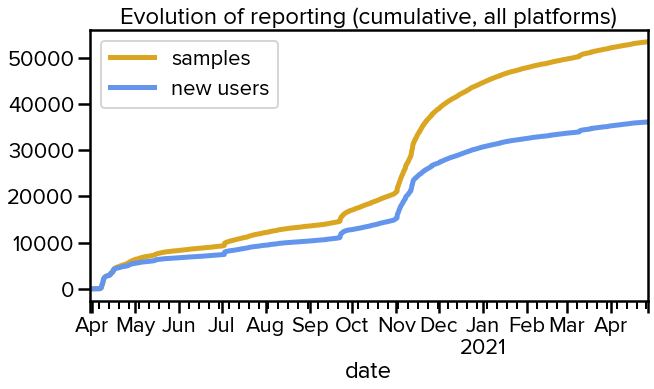

In [7]:
#cumulative hourly samples over time
series_samples = pd.Series(range(data.shape[0]), index=data.index) #a series with (range, index)
series_samples.resample('H').count().cumsum().plot(figsize=(10,5),lw=5, title="Evolution of reporting (cumulative, all platforms)", label='samples', color='goldenrod' ,) #resample hourly, apply cumulative sum, and plot

#cumulative hourly participants over time
series_users = pd.Series(range(tmp.shape[0]), index=tmp.index) #a series with (range, index)
series_users.resample('H').count().cumsum().plot(figsize=(10,5),lw=5, label='new users', color='cornflowerblue') #resample hourly, apply cumulative sum, and plot
#plt.savefig('evolution.png', bbox_inches='tight')

plt.legend()
plt.savefig('evolution.png', dpi=300, bbox_inches='tight')

In [8]:
#data validation note: until 10/4/2020 (21:39pm) we were recording only yes/no, then was changed to never/last14/over14
data["Covid-Tested"][data["Covid-Tested"]=='never'] = 'Not tested'

data["Covid-Tested"][data["Covid-Tested"]=='neverThinkHadCOVIDNever'] = 'Not tested'
data["Covid-Tested"][data["Covid-Tested"]=='neverThinkHadCOVIDNow'] = 'Not tested (symptoms now)'
data["Covid-Tested"][data["Covid-Tested"]=='neverThinkHadCOVIDOver14'] = 'Not tested (symptoms past)'
data["Covid-Tested"][data["Covid-Tested"]=='neverThinkHadCOVIDLast14'] = 'Not tested (symptoms now)'


data["Covid-Tested"][data["Covid-Tested"]=='negativeNever'] = 'COVID-19 negative (always)'
data["Covid-Tested"][data["Covid-Tested"]=='negativeOver14'] = 'COVID-19 negative (past positive)'
data["Covid-Tested"][data["Covid-Tested"]=='negativeLast14'] = 'COVID-19 negative (recently positive)'

data["Covid-Tested"][data["Covid-Tested"]=='positiveOver14'] = 'COVID-19 positive (past)'
data["Covid-Tested"][data["Covid-Tested"]=='positiveLast14'] = 'COVID-19 positive'
data["Covid-Tested"][data["Covid-Tested"]=='last14'] = 'COVID-19 positive'
data["Covid-Tested"][data["Covid-Tested"]=='over14'] = 'COVID-19 positive (past)'

data["Covid-Tested"][data["Covid-Tested"]=='pnts'] = 'Prefer not to say'
data["Covid-Tested"][data["Covid-Tested"]=='ptns'] = 'Prefer not to say'
data["Covid-Tested"][data["Covid-Tested"]=='LocalizedStringKey(key: "pnts", hasFormatting: false, arguments: [])'] = 'Prefer not to say'

In [9]:
data["Covid-Tested"].value_counts()

Not tested                               34302
COVID-19 negative (always)                6450
Not tested (symptoms now)                 3345
COVID-19 negative (past positive)         2526
Not tested (symptoms past)                2303
COVID-19 positive                         1572
COVID-19 negative (recently positive)     1437
Prefer not to say                          924
COVID-19 positive (past)                   534
Name: Covid-Tested, dtype: int64

/Users/sdimi/anaconda3/lib/python3.6/site-packages/brokenaxes.py:294: UserWarning: FixedFormatter should only be used together with FixedLocator
  result.append(getattr(ax, method)(*args, **kwargs))


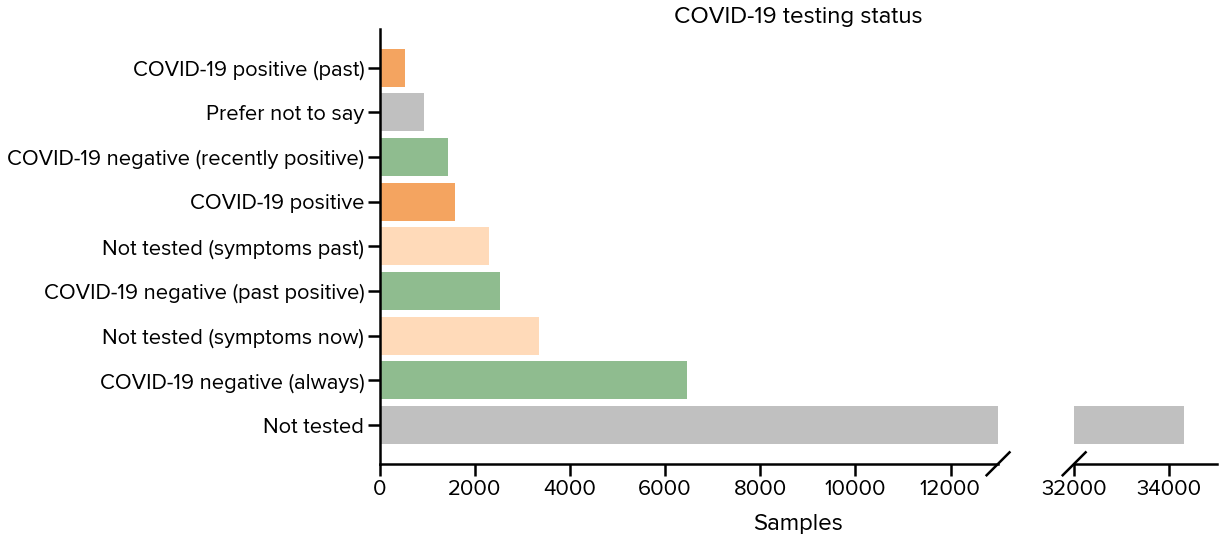

In [10]:
from brokenaxes import brokenaxes

plt.figure(figsize=(15,8))

categs =  data["Covid-Tested"].value_counts(normalize=False).index
y_pos = np.arange(len(categs))

#colors = ['silver','peachpuff','peachpuff','forestgreen','tomato', 'tomato', 'forestgreen', 'silver']

colors = ['silver','darkseagreen','peachpuff','darkseagreen',
          'peachpuff', 'sandybrown', 'darkseagreen','silver', 'sandybrown']

bax = brokenaxes(xlims=((0, 13000), (32000, 35000)))
width = 0.85 # the width of the bars 

bax.barh(y_pos,  data["Covid-Tested"].value_counts().values, width, align='center', color=colors)


#this library has an issue with replacing ticks with your own labels
#this was so tricky to get it right (https://github.com/bendichter/brokenaxes/issues/17)
bax.set_yticklabels(categs)
bax.axs[0].set_yticks(y_pos)

#bax.invert_yaxis()
bax.set_xlabel('Samples', labelpad = 50)

plt.title("COVID-19 testing status")
plt.savefig('covid.png', dpi=300, bbox_inches='tight')

## User-level statistics

In [11]:
#keep only one row per user (in order to calculate correct frequencies for age etc)
data = data.drop_duplicates(subset='Uid', keep="first")
data.shape

(36116, 100)

In [12]:
data.Age[data.Age=='16-19'] = '0-19'
data.Age[data.Age=='pnts'] = 'None'

In [13]:
data.Age.value_counts()

30-39       9570
20-29       8709
40-49       7157
50-59       4028
0-19        3329
60-69       1910
None         714
70-79        604
80-89         71
90-           19
Unter 20       1
Name: Age, dtype: int64

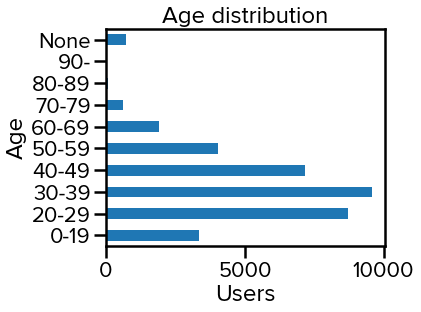

In [14]:
plt.figure(figsize=(5,4)) #reordering the categories by reindexing the df
data.Age.value_counts().reindex(["0-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89","90-", "None"]).plot(kind='barh', rot=0) #value_counts(normalize=True) for percentages

plt.ylabel('Age')
plt.xlabel('Users')
plt.title("Age distribution")
plt.savefig('age.png', dpi=300, bbox_inches='tight')

In [15]:
data.Sex[data.Sex=='ptns'] = 'Other/ \n None'
data.Sex[data.Sex=='pnts'] = 'Other/ \n None'
data.Sex[data.Sex=='Other'] = 'Other/ \n None'

In [16]:
data.Sex.value_counts(normalize=True)#.sum()

Male              0.623989
Female            0.362742
Other/ \n None    0.013269
Name: Sex, dtype: float64

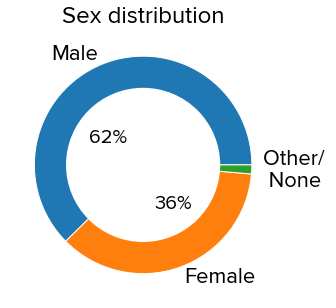

In [17]:
plt.figure(figsize=(5,5))
plt.title("Sex distribution")
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.text(-0.5,0.2,'62%',rotation=0, size=20)
plt.text(0.1,-0.4,'36%',rotation=0, size=20)
plt.pie(data.Sex.value_counts().values, labels=data.Sex.value_counts().index.values, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.savefig('sex.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
data.Smoking[data.Smoking=='ex'] = 'ex-smoker'
data.Smoking[data.Smoking=='1to10'] = '1-10 cigs'
data.Smoking[data.Smoking=='11to20'] = '11-20 cigs'
data.Smoking[data.Smoking=='ltOnce'] = '<1 cig'
data.Smoking[data.Smoking=='pnts'] = 'None'
data.Smoking[data.Smoking=='ptns'] = 'None'
data.Smoking[data.Smoking=='21+'] = '21+ cigs'
data.Smoking[data.Smoking=='ecig'] = 'e-cig'

In [19]:
data.Smoking.value_counts()

never         19776
ex-smoker      6382
1-10 cigs      3995
11-20 cigs     3071
<1 cig         1245
None            751
e-cig           468
21+ cigs        407
Name: Smoking, dtype: int64

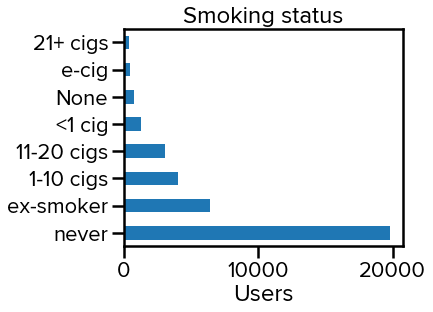

In [20]:
plt.figure(figsize=(5,4))
data.Smoking.value_counts().plot(kind='barh')

plt.xlabel('Users')
plt.title("Smoking status")
plt.savefig('smoking.png', dpi=300, bbox_inches='tight')

In [21]:
data.Location[data.Location=='unavailable'] = 'None'
data.Location[data.Location=='United Kingdom'] = 'UK'
data.Location[data.Location=='Argentina'] = 'Arg.'
data.Location[data.Location=='Portugal'] = 'Port.'
data.Location[data.Location=='Switzerland'] = 'Switz.'
data.Location[data.Location=='Sweden'] = 'Swed.'
data.Location[data.Location=='Russian Federation'] = 'Russia'
data.Location[data.Location==' Islamic Republic of'] = 'Iran' #the name Iran was lost because it was split by comma when we did str.rsplit

In [22]:
#countries with >60 users
top_countries = data.Location.value_counts().loc[lambda x : x>190]

In [23]:
data.Location.value_counts().sum()

34558

In [24]:
top_countries

None             11042
Italy             4698
United States     2829
UK                2019
Germany           1191
Brazil            1016
Iran               987
Spain              522
Russia             407
Greece             393
France             337
Switz.             307
Poland             307
Canada             272
India              262
Swed.              231
Arg.               224
Port.              198
Mexico             194
Name: Location, dtype: int64

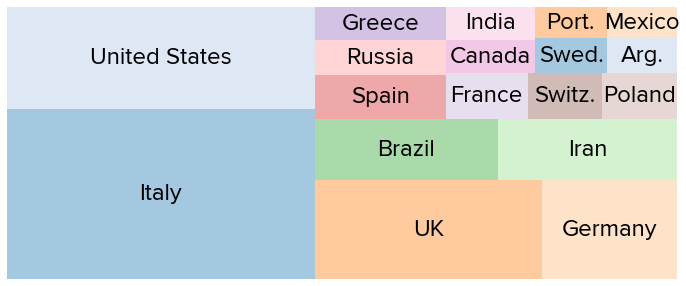

In [25]:
#libraries
import squarify # pip install squarify (algorithm for treemap)
from matplotlib import cm
#14 colors
cs=cm.tab20(np.arange(14))

plt.figure(figsize=(12,5))
# Change color
squarify.plot(sizes=top_countries.values[1:], label=top_countries.index[1:], color=cs,alpha=.4 )

plt.axis('off')
plt.savefig('countries.png', dpi=300, bbox_inches='tight')
plt.show()